In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
from pathlib import Path

import tensorflow as tf

from tensorflow.io import read_file
from tensorflow.image import decode_jpeg, resize

# Title

1. Create map-style dataset.
    - Create records `(filepath, class)`. The `filepath` is in a way a proxy to the data.
    - Read records using `tf.data.Dataset.from_tensor_slices()`.
1. Preprocess images.
    - Create function that preprocesses a single image.
        - read the bytes in the file
        - decode the raw bytes using jpg encoding
    - Apply the function: `dataset.map(func)`.
1. Reformat the labels to be numbers.
1. Include a resize step in the preprocessing. Every image shall have the same size.
1. Add shuffling (as early as possible).
1. Set random seeds.
1. Add mini-batches.
1. Add `repeat`.
1. Chain the steps (instead of assignment to the same variable).
1. Add scaling in the image preprocess func.
1. Implement methods of splitting to val, train, test:
    1. Save filepaths to external txt file.
        - Create `df.data.Dataset`, shuffle it, and save the output to a helper text file.
        - It can be read  instead of the raw filepaths.
    1. Use `sklearn`'s `train_test_split`.

## Heading

In [3]:
DATASET_DIR = Path().home() / 'Desktop' / 'datasets' / 'natural_images'
IMAGE_SHAPE = (100, 100)
IMAGE_SHAPE_CHANNELS = (100, 100, 3)
BATCH_SIZE = 8

SEED = 1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
unique_labels = [item.name for item in DATASET_DIR.glob('*')]
number_to_label = dict(enumerate(unique_labels))
label_to_number = {v: k for k, v in number_to_label.items()}
label_to_number

{'airplane': 0,
 'car': 1,
 'cat': 2,
 'dog': 3,
 'flower': 4,
 'fruit': 5,
 'motorbike': 6,
 'person': 7}

In [5]:
filepaths = []
labels = []

for path in DATASET_DIR.glob('*/*.jpg'):
    filepath = path.as_posix()
    label = label_to_number.get(path.parent.name)    
    filepaths.append(filepath)
    labels.append(label)

filepaths[0], labels[0]

('C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0000.jpg',
 0)

In [6]:
dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
[_ for _ in dataset.take(1)]

[(<tf.Tensor: shape=(), dtype=string, numpy=b'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0000.jpg'>,
  <tf.Tensor: shape=(), dtype=int32, numpy=0>)]

## Heading

In [7]:
def preprocess_image(filepath, label):
    file_bytes = read_file(filepath)
    image = decode_jpeg(file_bytes)
    image = resize(image, IMAGE_SHAPE)
    image = image / 256
    
    return image, label

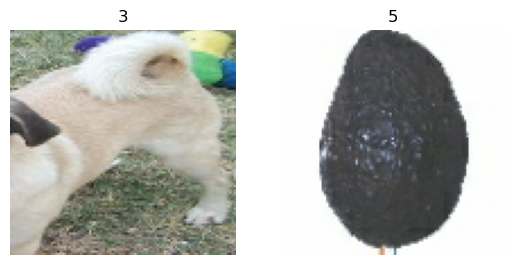

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
dataset = dataset.shuffle(buffer_size=len(dataset))
dataset = dataset.map(preprocess_image)

# Display the first 2 images after preprocessing and shuffling
i=1
for image, label in dataset.take(2):
    plt.subplot(1, 2, i)
    plt.imshow(image.numpy())
    plt.title(label.numpy())
    plt.axis('off')
    i+=1

plt.show()

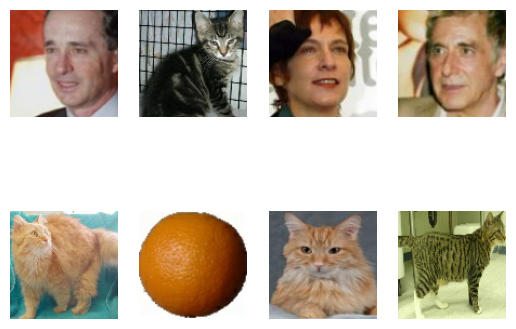

In [9]:
# Split into batches

dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
dataset = dataset.shuffle(buffer_size=len(dataset), seed=SEED)
dataset = dataset.map(preprocess_image)
dataset = dataset.batch(batch_size=BATCH_SIZE)

# Display the first minibatch
for minibatch in dataset.take(1):
    images = minibatch[0].numpy()
    for i, image in enumerate(images):
        plt.subplot(2, BATCH_SIZE // 2, i+1)
        plt.imshow(image)
        plt.axis('off')
    
    plt.show()

In [10]:
# Add `repeat`. Chain the steps.

dataset = (
    tf.data.Dataset.from_tensor_slices((filepaths, labels))
    .shuffle(buffer_size=len(dataset), seed=SEED)
    .map(preprocess_image)
    .batch(batch_size=BATCH_SIZE)
    .repeat()
)

dataset

<RepeatDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [11]:
# One method of splitting the data to train, val, and test sets

a_split = filepaths[:10]

list(tf.data.Dataset.from_tensor_slices(a_split)
 .shuffle(len(a_split))
 .as_numpy_iterator()
)

# save split to text files and read isstead of reading the filepaths names each time

[b'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0003.jpg',
 b'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0008.jpg',
 b'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0000.jpg',
 b'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0009.jpg',
 b'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0001.jpg',
 b'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0006.jpg',
 b'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0007.jpg',
 b'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0005.jpg',
 b'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0002.jpg',
 b'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0004.jpg']

In [12]:
# Second method of splitting the data

from sklearn.model_selection import train_test_split

# First split to create [train+val] and test
train_test_split(filepaths[:10], stratify = labels[:10], test_size=0.3)

# Second, to create val and train
# train_test_split(...)

[['C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0001.jpg',
  'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0004.jpg',
  'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0002.jpg',
  'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0006.jpg',
  'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0009.jpg',
  'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0000.jpg',
  'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0003.jpg'],
 ['C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0005.jpg',
  'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0007.jpg',
  'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0008.jpg']]

In [13]:
# Add `repeat`. Chain the steps.

dataset = (
    tf.data.Dataset.from_tensor_slices((filepaths, labels))
    .shuffle(buffer_size=len(dataset), seed=SEED)
    .map(preprocess_image)
    .batch(batch_size=BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
    .repeat()
)

dataset

TypeError: The dataset is infinite.

## Off-topic